In [37]:
import heapq, random, itertools, operator
import matplotlib.pyplot as plt
from sympy import IndexedBase

In [22]:
def take(iterable, n):
    yield from map(lambda p: p[1], zip(range(n), iterable))

In [23]:
a = IndexedBase('a')
actions = [a[i] for i in range(10)]
actions

[a[0], a[1], a[2], a[3], a[4], a[5], a[6], a[7], a[8], a[9]]

In [24]:
q_star = { a: random.gauss(0, 1) for a in actions }

In [25]:
def rewarder(q_star, process):
    
    reward = None
    
    while True:
        
        action, q, n, t, by = process.send(reward)
        qs = q_star[action]
        reward = random.gauss(qs, 1)
        yield action, q, qs, by, reward

In [26]:
def k_armed_bandit(actions, epsilon):
    
    Q = [(0, 0, i, a) for i, a in enumerate(actions)]
    heapq._heapify_max(Q)
    
    for t in itertools.count():

        by = None
        if random.random() > epsilon:
            q, n, i, a = heapq._heappop_max(Q)
            by = 'e' # exploiting flag
        else:
            j = random.randrange(0, len(Q))
            q, n, i, a = Q.pop(j)
            heapq._heapify_max(Q) # takes linear time to maintain the heap invariant.
            by = 's' # search flag
        
        n_next = n + 1
        reward = yield (a, q, n_next, t, by)
        
        q_updated = q + ((reward - q)/n_next)
        
        Q.append((q_updated, n_next, i, a))
        heapq._heapify_max(Q)#, 0, len(Q)-1)

In [42]:
R = rewarder(q_star, k_armed_bandit(actions, epsilon=0.1))

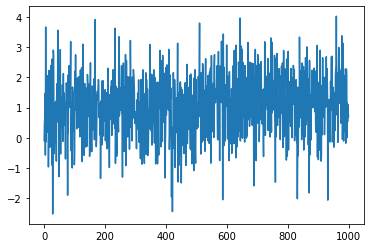

In [43]:
plt.plot(list(take(map(lambda tup: tup[-1], R), 1000)))

In [44]:
def avg(*args):
    return sum(args)/len(args)

In [45]:
A = [map(lambda tup: tup[-1], rewarder(q_star, k_armed_bandit(actions, 0.0))) for i in range(2_000)]
A = list(take(map(avg, *A), 1000))

In [46]:
B = [map(lambda tup: tup[-1], rewarder(q_star, k_armed_bandit(actions, 0.1))) for i in range(2_000)]
B = list(take(map(avg, *B), 1000))

In [47]:
C = [map(lambda tup: tup[-1], rewarder(q_star, k_armed_bandit(actions, 0.01))) for i in range(2_000)]
C = list(take(map(avg, *C), 1000))

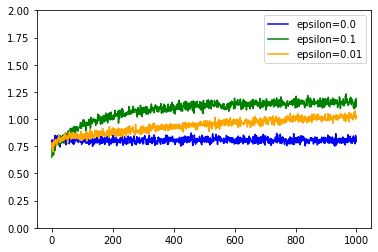

In [48]:
plt.ylim(0, 2)
plt.plot(A, label='epsilon=0.0', color='blue')
plt.plot(B, label='epsilon=0.1', color='green')
plt.plot(C, label='epsilon=0.01', color='orange')
plt.legend();

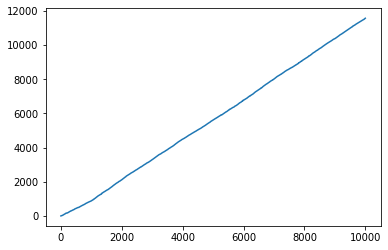

In [38]:
plt.plot(list(take(itertools.accumulate(map(lambda tup: tup[-1], R), operator.add), 10000)))

In [39]:
list(take(R, 100))

[(a[3], 1.304042053831909, 1.3089274773758124, 'e', 0.2873770230350059),
 (a[3], 1.3039173555575565, 1.3089274773758124, 'e', 0.6894670327194447),
 (a[3], 1.303841999864297, 1.3089274773758124, 'e', 1.966262452557162),
 (a[3], 1.3039232286138607, 1.3089274773758124, 'e', 1.2352318046174802),
 (a[3], 1.3039148064186674, 1.3089274773758124, 'e', 1.0269223304708945),
 (a[3], 1.3038808487778746, 1.3089274773758124, 'e', 0.9295141907813615),
 (a[3], 1.3038349592635332, 1.3089274773758124, 'e', 0.9536299875770604),
 (a[3], 1.3037920367274765, 1.3089274773758124, 'e', 3.436250468940811),
 (a[3], 1.3040533674176986, 1.3089274773758124, 's', 3.242736186092144),
 (a[3], 1.3042909219843786, 1.3089274773758124, 'e', 1.7728919677867019),
 (a[3], 1.304348334511431, 1.3089274773758124, 'e', 3.8185073307112956),
 (a[3], 1.3046563289982864, 1.3089274773758124, 'e', 0.4046208226774508),
 (a[3], 1.3045460845707606, 1.3089274773758124, 'e', -0.006415551506443462),
 (a[3], 1.304385525889061, 1.308927477375